In [1]:
%matplotlib inline
import os, json
# os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycococreatortools import pycococreatortools
from icevision import models, parsers, show_records, tfms, Dataset, Metric, COCOMetric, COCOMetricType
from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *
from sklearn.metrics import confusion_matrix, f1_score
import skimage.io as skio
from ceruleanml.coco_stats import all_sample_stat_lists
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from ceruleanml import preprocess
from ceruleanml import data

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /root/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
bs_d ={512:8, 256:32, 224:32, 128:16, 64:128} # Batch Size for each image size
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2} # Learning Rate for each image size
mins_d = {512:5.88, 256:1.5, 224:2.5, 128:1.5, 64:1.1} 
run_list = [[128, 31]]*40 # List of tuples, where the tuples are [px size, training time in minutes]
init_size = run_list[0][0]
fp16 = False
n = "all"
arch = 34
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 10
remap_dict = {
    "ambiguous": None,
}

model_type = models.torchvision.mask_rcnn

In [4]:
backbone = model_type.backbones.resnet34_fpn(pretrained=True)

### Important! 

Make sure you have copied the dataset to the local SSD of the VM at /root. Loading the data from a GCP bucket takes a full 2 minutes compared to 17 seconds when data is on the SSD.

You can run the following for example to copy a dataset from the bucket to the vm quickly.

```
mkdir tile-cerulean-v2-partial-with-context
gsutil -m rsync -ravzp gs://ceruleanml/tile-cerulean-v2-partial-with-context tile-cerulean-v2-partial-with-context
```

In [5]:
data_path = "/root/"
mount_path = "/root/data"

In [6]:
### Parsing COCO Dataset with Icevision

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

with_context=False
mount_path = "/root/"
train_set = "train-with-context-512"
tiled_images_folder_train = "tiled_images"
json_name_train = "instances_TiledCeruleanDatasetV2.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-with-context-512"
tiled_images_folder_val= "tiled_images"
json_name_val = "instances_TiledCeruleanDatasetV2.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df

record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

  0%|          | 0/3863 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

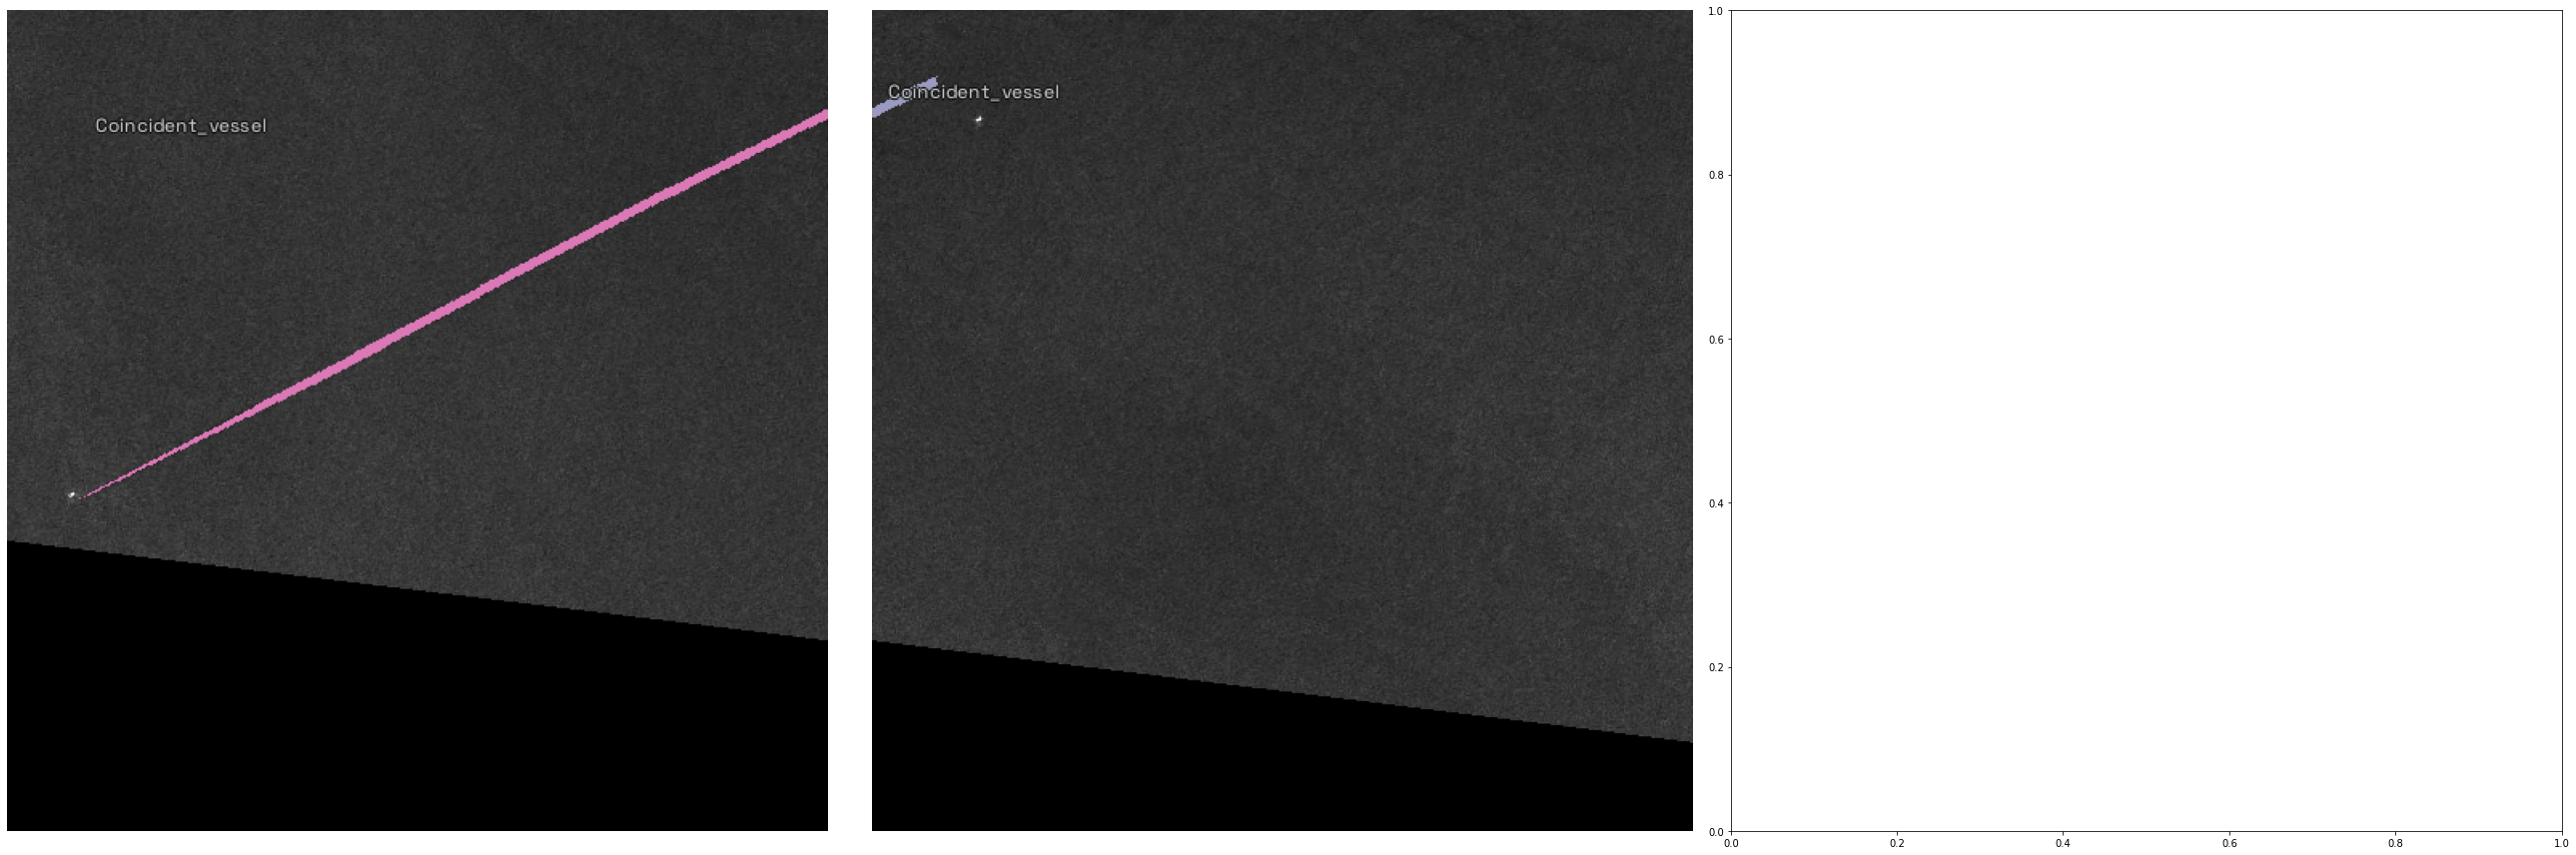

In [7]:
%matplotlib inline
show_records(record_collection_with_negative_small_filtered_train[0:2], ncols=3, class_map=class_map, display_mask=True, display_bbox=False)

In [8]:
valid_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=init_size)])
train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

## custom iou metric because of -1 error

In [9]:
__all__ = ["IoUMetric", "IoUMetricType"]


class IoUMetricType(Enum):
    """Available options for `COCOMetric`."""

    bbox = "bbox"
    mask = "segm"
    keypoint = "keypoints"


class IoUMetric(Metric):
    """Wrapper around [cocoapi evaluator](https://github.com/cocodataset/cocoapi)
    Calculates average precision.
    # Arguments
        metric_type: Dependent on the task you're solving.
        print_summary: If `True`, prints a table with statistics.
        show_pbar: If `True` shows pbar when preparing the data for evaluation.
    """

    def __init__(
        self,
        metric_type: IoUMetricType = IoUMetricType.mask,
        iou_thresholds: Optional[Sequence[float]] = None,
        print_summary: bool = False, 
        show_pbar: bool = True,
    ):
        self.metric_type = metric_type
        self.iou_thresholds = iou_thresholds
        self.print_summary = print_summary
        self.show_pbar = show_pbar
        self._records, self._preds = [], []

    def _reset(self):
        self._records.clear()
        self._preds.clear()

    def accumulate(self, preds):
        for pred in preds:
            self._records.append(pred.ground_truth)
            self._preds.append(pred.pred)

    def finalize(self) -> Dict[str, float]:
        with CaptureStdout():
            coco_eval = create_coco_eval(
                records=self._records,
                preds=self._preds,
                metric_type=self.metric_type.value,
                iou_thresholds=self.iou_thresholds,
                show_pbar=self.show_pbar,
            )
            coco_eval.evaluate()
            coco_eval.accumulate()

        with CaptureStdout(propagate_stdout=self.print_summary):
            coco_eval.summarize()

        stats = coco_eval.stats
        ious = coco_eval.ious

        ious_l = []
        for iou in ious.values():
            if isinstance(iou, np.ndarray):
                iou = iou.tolist()
            else:
                iou = iou
            ious_l.append(iou)
        
        flat_ious_l = [item for sublist in ious_l for item in sublist]
        if len(flat_ious_l) == 0:
            flat_ious_l.append([0])
        flat_ious_l = [item for items in flat_ious_l for item in items]
        ious_avg = np.array(flat_ious_l).mean()
        ious_min = np.array(flat_ious_l).min()
        ious_max = np.array(flat_ious_l).max()
        
        logs = {
            #"Min IoU area=all": ious_min,
            #"Max IoU area=all": ious_max,
            "Avg. IoU area=all": ious_avg, 
        }
        self._reset()
        
        
        return logs

In [10]:
train_ds = Dataset(record_collection_with_negative_small_filtered_train, train_tfms)
valid_ds = Dataset(record_collection_with_negative_small_filtered_val, valid_tfms)
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=6, shuffle=False)
infer_dl = model_type.infer_dl(valid_ds, batch_size=32, shuffle=False)
# metrics = [IoUMetric(metric_type=IoUMetricType.mask), COCOMetric(metric_type=COCOMetricType.bbox)]

model = model_type.model(backbone=backbone(pretrained=True), num_classes=7)
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model) # metrics=metrics # , cbs=SaveModelCallback(monitor='COCOMetric')

running_total_epochs = {}

1 train epoch is about 4 minutes. 1 validation epoch of 76 samples is also about a minute.

# No Progressive Resize

In [11]:
#learner.fine_tune(35, 3e-3) # 3e-3 is hand selected lr
# learn.fine_tune(2, lr.valley) #, freeze_epochs=2)

## Progressive Resizing

In [ ]:
from icevision.models.utils import get_dataloaders
from icevision.engines.fastai import convert_dataloaders_to_fastai

for size, total_train_time in run_list:
    epochs = max(int(total_train_time/mins_d[size]), 1)
    bs = bs_d[size]
    lr = lr_d[size]
    valid_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size)])
    train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size)])
    ds, dls = get_dataloaders(model_type, [record_collection_with_negative_small_filtered_train, record_collection_with_negative_small_filtered_val], [train_tfms, valid_tfms], batch_size=bs, num_workers=8)
    fastai_dls = convert_dataloaders_to_fastai(dls=dls)
    learner.dls = fastai_dls
    print(f"Training time is: {total_train_time} minutes")
    print("starting from running total", running_total_epochs)
    print("image size", size)
    print("batch size", bs)
    print("arch", arch)
    print("lr", lr)
    print("n chips", n)
    print("context", with_context)
    print("epochs", epochs)

    learner.fine_tune(epochs, lr, freeze_epochs=0) # cbs=cbs

    running_total_epochs[size] = sum(filter(None,[running_total_epochs.get(size),epochs]))

Training time is: 31 minutes
starting from running total {}
image size 128
batch size 16
arch 34
lr 0.003
n chips all
context False
epochs 20


epoch,train_loss,valid_loss,time


/root/work/.ice-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Instance Evaluation

In [15]:
type(learn)


fastai.learner.Learner

Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plottin

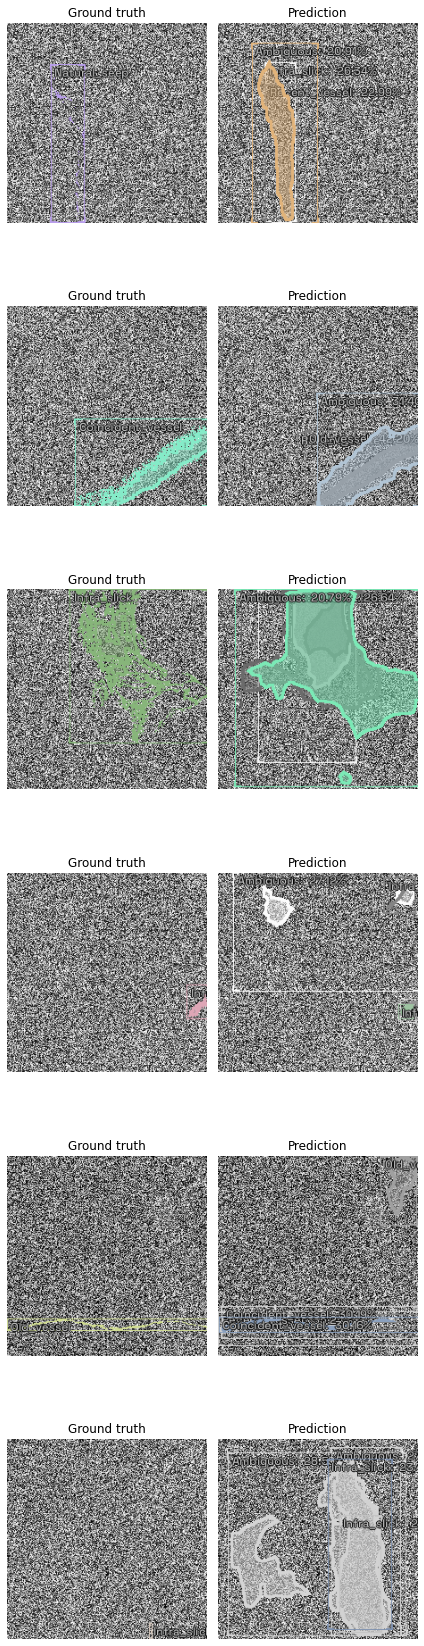

In [20]:
model_type.show_results(model, valid_ds, detection_threshold=.2)

a TODO is to debug the COCOMetric, it should not be -1 given that we are now acheiving detections that intersect with groundtruth.

In [ ]:
!mkdir {mount_path}/experiments/cv2/05062022_ep10

In [ ]:
torch.save(model, f'{mount_path}/experiments/cv2/05062022_ep10/05062022_ep10.pth')

In [ ]:
print(f"approximate time to train 30 epochs in minutes: {25*30/60}")


The predictions above .7 confidence that roughly line up with groundtruth demonstrates that icevision-trained models can produce predictions that look like they are headed in the correct direction, even for an imperfect training set.

In [ ]:
model_type.show_results??

In [ ]:
model.eval()

In [ ]:
x = model_type.show_results(model, valid_ds, detection_threshold=.6) 
plt.savefig("inference_results.png")

In [ ]:
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
d = preds[10].as_dict()

In [ ]:
d

In [ ]:
v = valid_records[10].as_dict()

In [ ]:
v

In [ ]:
v_masks = v['detection']['masks'] #[0].to_mask(d['common']['height'],d['common']['width']).data

In [ ]:
d_masks = d['detection']['masks'] #[0].to_mask(d['common']['height'],d['common']['width']).data

In [ ]:
# flatten our mask arrays and use scikit-learn to create a confusion matrix
flat_preds = np.concatenate(d_masks).flatten()
flat_truth = np.concatenate(v_masks).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

classes = [1,2,3,4,5,6]

#%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

plt.savefig(f'{ROOT_DIR}cm.png')


# compute f1 score
f1 = f1_score(flat_truth, flat_preds, average='macro')

print("cm: ", cm)
print("f1: ", f1)
